In [1]:
import numpy as np
import random
import scipy.interpolate as interp
import matplotlib.pyplot as plt
H_in_kJmol = 2625.499639
R = 8.314 # J/(K*mol)
T = 300   # K
RT = R*T/1000.0 # kJ / mol
RT_au = RT/2625.5
kB          = 1.380648e-23      # J / K
H_to_J      = 4.359744e-18      #
kB_a        = kB / H_to_J       # Hartree / K

In [15]:
import os
cwd = os.getcwd()
data = np.loadtxt('../chlor-fluor-ethan/benchmark/meta_eABF/height1/bias_out.dat', skiprows=1)
os.chmod('../chlor-fluor-ethan/benchmark/meta_eABF/height1/bias_out.dat', 0o444)

In [12]:
def pot(x, y):
    a=0.005
    b=0.040
    d=40.0
    e=20.0
    exp_1 = np.exp((-a*(x-d)*(x-d)) + (-b*(y-e)*(y-e)))
    exp_2 = np.exp((-a*(x+d)*(x+d)) + (-b*(y+e)*(y+e)))
    return - np.log(exp_1 + exp_2)

In [3]:
def interp(data, x_bins, y_bins, lenx, leny, dxi_1, dxi_2):
    F_orig = data[:,6].reshape(y_bins, x_bins)*H_in_kJmol
    prob_surface = np.exp(F_orig/RT)
    prob_surface /= prob_surface.sum()*dxi_1*dxi_2
    F_orig = RT*np.log(prob_surface, out=np.zeros_like(prob_surface), where=(prob_surface!=0))
    F_orig -= F_orig.min()
    I = np.zeros(shape=(leny,lenx), dtype=np.float)
    I[::4,::4]  = F_orig
    I[::4,2::4] = 0.5*I[::4,:-4:4] + 0.5*I[::4,4::4]
    I[::4,1::4] = 0.5*I[::4,2::4]  + 0.5*I[::4,:-4:4]
    I[::4,3::4] = 0.5*I[::4,2::4]  + 0.5*I[::4, 4::4]
    I[2::4]     = 0.5*I[:-4:4]     + 0.5*I[4::4]
    I[1::4]     = 0.5*I[2::4]      + 0.5*I[:-4:4]
    I[3::4]     = 0.5*I[2::4]      + 0.5*I[4::4]
    return I

In [4]:
data = np.loadtxt('reference/bias_out_200000.dat', skiprows=1)
xi_1 = data[:,0]
xi_2 = data[:,1]
minxi_1 = xi_1.min()
maxxi_1 = xi_1.max()
minxi_2 = xi_2.min()
maxxi_2 = xi_2.max()
dxi_2 = xi_2[1]-xi_2[0]
x_bins = int((maxxi_2-minxi_2)/dxi_2 + 1)
y_bins = int(xi_1.shape[0]/x_bins)
xi_1 = xi_1.reshape(y_bins, x_bins)
xi_2 = xi_2.reshape(y_bins, x_bins)
dxi_1 = xi_1[1,0]-xi_1[0,0]        
dy = dxi_1 / 4
dx = dxi_2 / 4
minx = minxi_2
maxx = maxxi_2
miny = minxi_1
maxy = maxxi_1
x = np.arange(minx, maxx+dx, dx)
y = np.arange(miny, maxy+dy, dy)
lenx = len(x)
leny = len(y)
xx, yy = np.meshgrid(x,y)

In [5]:
ref_1ns = np.loadtxt('reference/bias_out_100000.dat', skiprows=1)
ref_3ns = np.loadtxt('reference/bias_out_600000.dat', skiprows=1)
ref_5ns = np.loadtxt('reference/bias_out_1000000.dat', skiprows=1)
ref_1ns = interp(ref_1ns, x_bins, y_bins,lenx,leny,dxi_1,dxi_2)-pot(xx,yy)
ref_3ns = interp(ref_3ns, x_bins, y_bins,lenx,leny,dxi_1,dxi_2)-pot(xx,yy)
ref_5ns = interp(ref_5ns, x_bins, y_bins,lenx,leny,dxi_1,dxi_2)-pot(xx,yy)

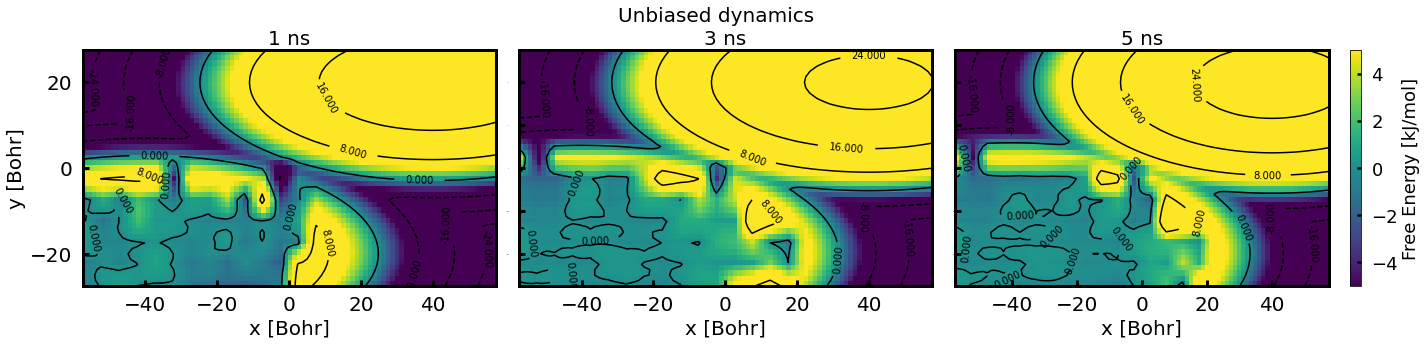

In [6]:
# Plotting
plt.rcParams["figure.figsize"] = [20,5]
plt.rcParams["axes.titlesize"] = 20
vmin = -5
vmax = 5
fig, axs = plt.subplots(ncols=3)
#
CS = axs[0].contour(xx, yy, ref_1ns, colors='black', zorder=3)
plt.clabel(CS, CS.levels, inline='true', fontsize=10, fmt="%5.3f")
im0 = axs[0].imshow(ref_1ns, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], zorder=1, interpolation='None', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
axs[0].tick_params(axis='y',length=6,width=3,labelsize=20, pad=10, direction='in')
axs[0].set(title='1 ns')
axs[0].set_ylabel('y [Bohr]', fontsize=20)
#
CS = axs[1].contour(xx, yy,ref_3ns, colors='black', zorder=3)
plt.clabel(CS, CS.levels, inline='true', fontsize=10, fmt="%5.3f")
im1 = axs[1].imshow(ref_3ns, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], zorder=1, interpolation='None', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
axs[1].tick_params(axis='y',length=6,width=3,labelsize=0, pad=10, direction='in')
axs[1].set(title='3 ns')
#
CS = axs[2].contour(xx, yy, ref_5ns, colors='black', zorder=3)
plt.clabel(CS, CS.levels, inline='true', fontsize=10, fmt="%5.3f")
im2 = axs[2].imshow(ref_5ns, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], zorder=1, interpolation='None', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
axs[2].set(title='5 ns')
axs[2].tick_params(axis='y',length=6,width=3,labelsize=0, pad=0, direction='in')
#
cb2 = plt.colorbar(im2, ax=axs[2], fraction=0.044)
cb2.ax.set_ylabel('Free Energy [kJ/mol]', fontsize=18)
cb2.ax.tick_params(length=4,width=2.5,labelsize=18, pad=10, direction='in')
#
for ax in axs:
    ax.set_xlabel(r'x [Bohr]', fontsize=20)
    ax.spines['bottom'].set_linewidth('3')
    ax.spines['top'].set_linewidth('3')
    ax.spines['left'].set_linewidth('3')
    ax.spines['right'].set_linewidth('3')
    ax.tick_params(axis='x',length=6,width=3,labelsize=20, pad=10, direction='in')
#
fig.suptitle('Unbiased dynamics', fontsize=20, y=0.95)
plt.tight_layout()
plt.savefig("reference_diff.png", dpi=400)
plt.show()
plt.close()

In [7]:
data = np.loadtxt('WTM/bias_out_200000.dat', skiprows=1)
xi_1 = data[:,0]
xi_2 = data[:,1]
minxi_1 = xi_1.min()
maxxi_1 = xi_1.max()
minxi_2 = xi_2.min()
maxxi_2 = xi_2.max()
dxi_2 = xi_2[1]-xi_2[0]
x_bins = int((maxxi_2-minxi_2)/dxi_2 + 1)
y_bins = int(xi_1.shape[0]/x_bins)
xi_1 = xi_1.reshape(y_bins, x_bins)
xi_2 = xi_2.reshape(y_bins, x_bins)
dxi_1 = xi_1[1,0]-xi_1[0,0]        
dy = dxi_1 / 4
dx = dxi_2 / 4
minx = minxi_2
maxx = maxxi_2
miny = minxi_1
maxy = maxxi_1
x = np.arange(minx, maxx+dx, dx)
y = np.arange(miny, maxy+dy, dy)
lenx = len(x)
leny = len(y)
xx, yy = np.meshgrid(x,y)

In [8]:
WTM_1ns = np.loadtxt('WTM_offgrid/bias_out_200000.dat', skiprows=1)
WTM_3ns = np.loadtxt('WTM_offgrid/bias_out_600000.dat', skiprows=1)
WTM_5ns = np.loadtxt('WTM_offgrid/bias_out_1000000.dat', skiprows=1)
WTM_1ns = interp(WTM_1ns, x_bins, y_bins,lenx,leny,dxi_1,dxi_2)-pot(xx,yy)
WTM_3ns = interp(WTM_3ns, x_bins, y_bins,lenx,leny,dxi_1,dxi_2)-pot(xx,yy)
WTM_5ns = interp(WTM_5ns, x_bins, y_bins,lenx,leny,dxi_1,dxi_2)-pot(xx,yy)

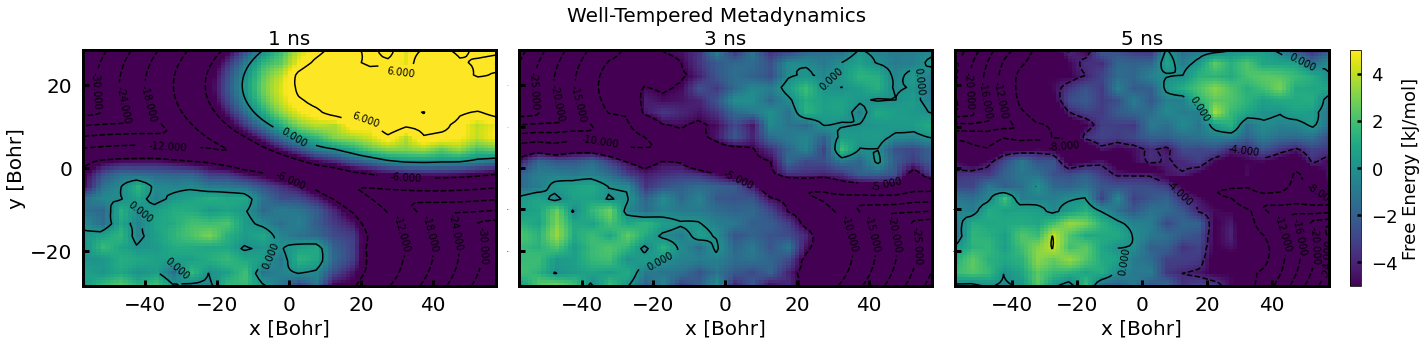

In [9]:
# Plotting
plt.rcParams["figure.figsize"] = [20,5]
plt.rcParams["axes.titlesize"] = 20
vmin = -5
vmax = 5
fig, axs = plt.subplots(ncols=3)
#
CS = axs[0].contour(xx, yy, WTM_1ns, colors='black', zorder=3)
plt.clabel(CS, CS.levels, inline='true', fontsize=10, fmt="%5.3f")
im0 = axs[0].imshow(WTM_1ns, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], zorder=1, interpolation='None', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
axs[0].tick_params(axis='y',length=6,width=3,labelsize=20, pad=10, direction='in')
axs[0].set(title='1 ns')
axs[0].set_ylabel('y [Bohr]', fontsize=20)
#
CS = axs[1].contour(xx, yy, WTM_3ns, colors='black', zorder=3)
plt.clabel(CS, CS.levels, inline='true', fontsize=10, fmt="%5.3f")
im1 = axs[1].imshow(WTM_3ns, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], zorder=1, interpolation='None', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
axs[1].tick_params(axis='y',length=6,width=3,labelsize=0, pad=10, direction='in')
axs[1].set(title='3 ns')
#
CS = axs[2].contour(xx, yy, WTM_5ns, colors='black', zorder=3)
plt.clabel(CS, CS.levels, inline='true', fontsize=10, fmt="%5.3f")
im2 = axs[2].imshow(WTM_5ns, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], zorder=1, interpolation='None', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
axs[2].set(title='5 ns')
axs[2].tick_params(axis='y',length=6,width=3,labelsize=0, pad=0, direction='in')
#
cb2 = plt.colorbar(im2, ax=axs[2], fraction=0.044)
cb2.ax.set_ylabel('Free Energy [kJ/mol]', fontsize=18)
cb2.ax.tick_params(length=4,width=2.5,labelsize=18, pad=10, direction='in')
#
for ax in axs:
    ax.set_xlabel(r'x [Bohr]', fontsize=20)
    ax.spines['bottom'].set_linewidth('3')
    ax.spines['top'].set_linewidth('3')
    ax.spines['left'].set_linewidth('3')
    ax.spines['right'].set_linewidth('3')
    ax.tick_params(axis='x',length=6,width=3,labelsize=20, pad=10, direction='in')
#
fig.suptitle('Well-Tempered Metadynamics', fontsize=20, y=0.95)
plt.tight_layout()
plt.savefig("WTM_diff.png", dpi=400)
plt.show()
plt.close()

In [10]:
Meta_1ns   = np.loadtxt('metaD_offgrid/bias_out_200000.dat', skiprows=1)
Meta_3ns = np.loadtxt('metaD_offgrid/bias_out_600000.dat', skiprows=1)
Meta_5ns   = np.loadtxt('metaD_offgrid/bias_out_1000000.dat', skiprows=1)
Meta_1ns = interp(Meta_1ns, x_bins, y_bins,lenx,leny,dxi_1,dxi_2)-pot(xx,yy)
Meta_3ns = interp(Meta_3ns, x_bins, y_bins,lenx,leny,dxi_1,dxi_2)-pot(xx,yy)
Meta_5ns = interp(Meta_5ns, x_bins, y_bins,lenx,leny,dxi_1,dxi_2)-pot(xx,yy)

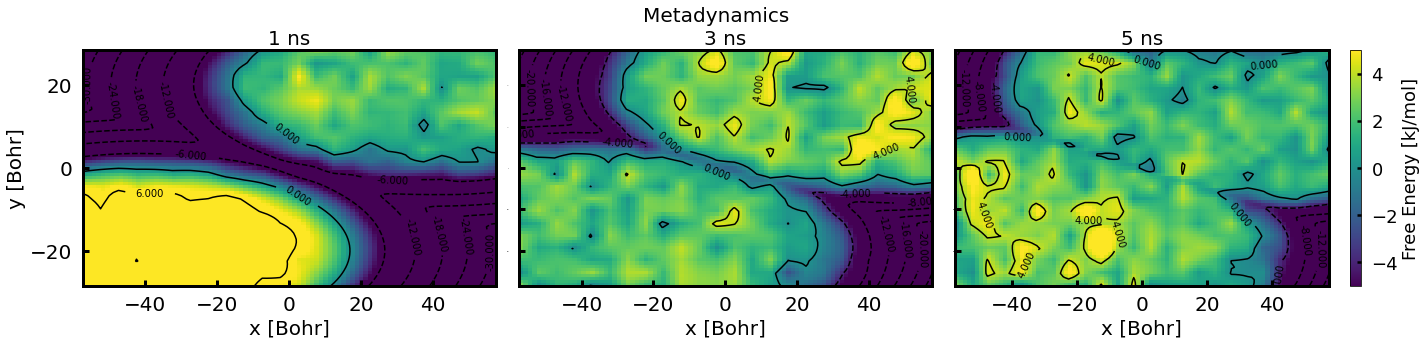

In [11]:
# Plotting
plt.rcParams["figure.figsize"] = [20,5]
plt.rcParams["axes.titlesize"] = 20
vmin = -5
vmax = 5
fig, axs = plt.subplots(ncols=3)
#
CS = axs[0].contour(x, y, Meta_1ns, colors='black', zorder=3)
plt.clabel(CS, CS.levels, inline='true', fontsize=10, fmt="%5.3f")
im0 = axs[0].imshow(Meta_1ns, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], zorder=1, interpolation='None', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
axs[0].tick_params(axis='y',length=6,width=3,labelsize=20, pad=10, direction='in')
axs[0].set(title='1 ns')
axs[0].set_ylabel('y [Bohr]', fontsize=20)
#
CS = axs[1].contour(x, y, Meta_3ns, colors='black', zorder=3)
plt.clabel(CS, CS.levels, inline='true', fontsize=10, fmt="%5.3f")
im1 = axs[1].imshow(Meta_3ns, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], zorder=1, interpolation='None', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
axs[1].tick_params(axis='y',length=6,width=3,labelsize=0, pad=10, direction='in')
axs[1].set(title='3 ns')
#
CS = axs[2].contour(x, y, Meta_5ns, colors='black', zorder=3)
plt.clabel(CS, CS.levels, inline='true', fontsize=10, fmt="%5.3f")
im2 = axs[2].imshow(Meta_5ns, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], zorder=1, interpolation='None', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
axs[2].set(title='5 ns')
axs[2].tick_params(axis='y',length=6,width=3,labelsize=0, pad=0, direction='in')
#
cb2 = plt.colorbar(im2, ax=axs[2], fraction=0.044)
cb2.ax.set_ylabel('Free Energy [kJ/mol]', fontsize=18)
cb2.ax.tick_params(length=4,width=2.5,labelsize=18, pad=10, direction='in')
#
for ax in axs:
    ax.set_xlabel(r'x [Bohr]', fontsize=20)
    ax.spines['bottom'].set_linewidth('3')
    ax.spines['top'].set_linewidth('3')
    ax.spines['left'].set_linewidth('3')
    ax.spines['right'].set_linewidth('3')
    ax.tick_params(axis='x',length=6,width=3,labelsize=20, pad=10, direction='in')
#
fig.suptitle('Metadynamics', fontsize=20, y=0.95)
plt.tight_layout()
plt.savefig("metaD_diff.png", dpi=400)
plt.show()
plt.close()

In [12]:
ABF_1ns = np.loadtxt('ABF/ABF_1ns.dat', skiprows=1)
ABF_3ns = np.loadtxt('ABF/ABF_3ns.dat', skiprows=1)
ABF_5ns = np.loadtxt('ABF/ABF_5ns.dat', skiprows=1)
lenx = len(np.unique(ABF_1ns[:,1]))
leny = len(np.unique(ABF_1ns[:,0]))
x = ABF_1ns[:,1].reshape(leny, lenx)
y = ABF_1ns[:,0].reshape(leny, lenx)
ABF_1ns = ABF_1ns[:,5].reshape(leny, lenx)
ABF_3ns = ABF_3ns[:,5].reshape(leny, lenx)
ABF_5ns = ABF_5ns[:,5].reshape(leny, lenx)
ABF_1ns -= ABF_1ns.min()
ABF_3ns -= ABF_3ns.min()
ABF_5ns -= ABF_5ns.min()
ABF_1ns -= pot(x,y)
ABF_3ns -= pot(x,y)
ABF_5ns -= pot(x,y)

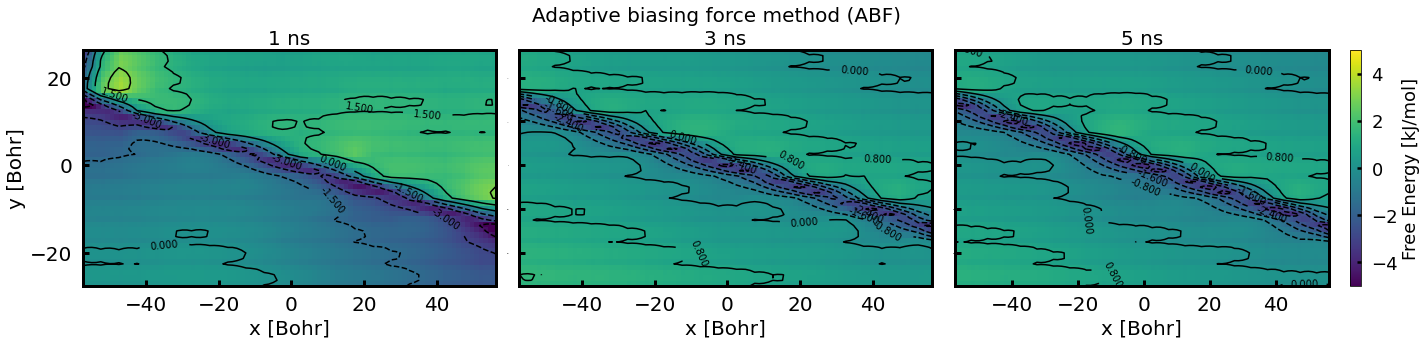

In [13]:
# Plotting
plt.rcParams["figure.figsize"] = [20,5]
plt.rcParams["axes.titlesize"] = 20
vmin = -5
vmax = 5
fig, axs = plt.subplots(ncols=3)
#
CS = axs[0].contour(x, y, ABF_1ns, colors='black', zorder=3)
plt.clabel(CS, CS.levels, inline='true', fontsize=10, fmt="%5.3f")
im0 = axs[0].imshow(ABF_1ns, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], zorder=1, interpolation='None', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
axs[0].tick_params(axis='y',length=6,width=3,labelsize=20, pad=10, direction='in')
axs[0].set(title='1 ns')
axs[0].set_ylabel('y [Bohr]', fontsize=20)
#
CS = axs[1].contour(x, y, ABF_3ns, colors='black', zorder=3)
plt.clabel(CS, CS.levels, inline='true', fontsize=10, fmt="%5.3f")
im1 = axs[1].imshow(ABF_3ns, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], zorder=1, interpolation='None', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
axs[1].tick_params(axis='y',length=6,width=3,labelsize=0, pad=10, direction='in')
axs[1].set(title='3 ns')
#
CS = axs[2].contour(x, y, ABF_5ns, colors='black', zorder=3)
plt.clabel(CS, CS.levels, inline='true', fontsize=10, fmt="%5.3f")
im2 = axs[2].imshow(ABF_5ns, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], zorder=1, interpolation='None', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
axs[2].set(title='5 ns')
axs[2].tick_params(axis='y',length=6,width=3,labelsize=0, pad=0, direction='in')
#
cb2 = plt.colorbar(im2, ax=axs[2], fraction=0.044)
cb2.ax.set_ylabel('Free Energy [kJ/mol]', fontsize=18)
cb2.ax.tick_params(length=4,width=2.5,labelsize=18, pad=10, direction='in')
#
for ax in axs:
    ax.set_xlabel(r'x [Bohr]', fontsize=20)
    ax.spines['bottom'].set_linewidth('3')
    ax.spines['top'].set_linewidth('3')
    ax.spines['left'].set_linewidth('3')
    ax.spines['right'].set_linewidth('3')
    ax.tick_params(axis='x',length=6,width=3,labelsize=20, pad=10, direction='in')
#
fig.suptitle('Adaptive biasing force method (ABF)', fontsize=20, y=0.95)
plt.tight_layout()
plt.savefig("ABF_diff.png", dpi=400)
plt.show()
plt.close()

In [14]:
eABF_1ns = np.loadtxt('eABF/eABF_1ns.dat', skiprows=1)
eABF_3ns = np.loadtxt('eABF/eABF_3ns.dat', skiprows=1)
eABF_5ns = np.loadtxt('eABF/eABF_5ns.dat', skiprows=1)
eABF_1ns = eABF_1ns[:,5].reshape(leny, lenx)
eABF_3ns = eABF_3ns[:,5].reshape(leny, lenx)
eABF_5ns = eABF_5ns[:,5].reshape(leny, lenx)
eABF_1ns -= eABF_1ns.min()
eABF_3ns -= eABF_3ns.min()
eABF_5ns -= eABF_5ns.min()
eABF_1ns -= pot(x,y)
eABF_3ns -= pot(x,y)
eABF_5ns -= pot(x,y)

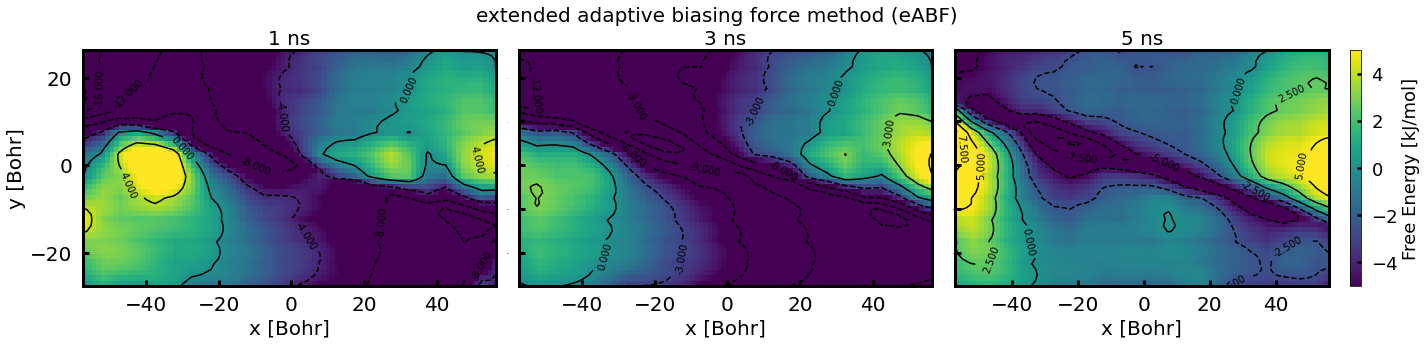

In [15]:
# Plotting
plt.rcParams["figure.figsize"] = [20,5]
plt.rcParams["axes.titlesize"] = 20
vmin = -5
vmax = 5
fig, axs = plt.subplots(ncols=3)
#
CS = axs[0].contour(x, y, eABF_1ns, colors='black', zorder=3)
plt.clabel(CS, CS.levels, inline='true', fontsize=10, fmt="%5.3f")
im0 = axs[0].imshow(eABF_1ns, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], zorder=1, interpolation='None', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
axs[0].tick_params(axis='y',length=6,width=3,labelsize=20, pad=10, direction='in')
axs[0].set(title='1 ns')
axs[0].set_ylabel('y [Bohr]', fontsize=20)
#
CS = axs[1].contour(x, y, eABF_3ns, colors='black', zorder=3)
plt.clabel(CS, CS.levels, inline='true', fontsize=10, fmt="%5.3f")
im1 = axs[1].imshow(eABF_3ns, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], zorder=1, interpolation='None', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
axs[1].tick_params(axis='y',length=6,width=3,labelsize=0, pad=10, direction='in')
axs[1].set(title='3 ns')
#
CS = axs[2].contour(x, y, eABF_5ns, colors='black', zorder=3)
plt.clabel(CS, CS.levels, inline='true', fontsize=10, fmt="%5.3f")
im2 = axs[2].imshow(eABF_5ns, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], zorder=1, interpolation='None', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
axs[2].set(title='5 ns')
axs[2].tick_params(axis='y',length=6,width=3,labelsize=0, pad=0, direction='in')
#
cb2 = plt.colorbar(im2, ax=axs[2], fraction=0.044)
cb2.ax.set_ylabel('Free Energy [kJ/mol]', fontsize=18)
cb2.ax.tick_params(length=4,width=2.5,labelsize=18, pad=10, direction='in')
#
for ax in axs:
    ax.set_xlabel(r'x [Bohr]', fontsize=20)
    ax.spines['bottom'].set_linewidth('3')
    ax.spines['top'].set_linewidth('3')
    ax.spines['left'].set_linewidth('3')
    ax.spines['right'].set_linewidth('3')
    ax.tick_params(axis='x',length=6,width=3,labelsize=20, pad=10, direction='in')
#
fig.suptitle('extended adaptive biasing force method (eABF)', fontsize=20, y=0.95)
plt.tight_layout()
plt.savefig("eABF_diff.png", dpi=400)
plt.show()
plt.close()

In [16]:
meta_eABF_1ns = np.loadtxt('meta_eABF/meta_eABF_1ns.dat', skiprows=1)
meta_eABF_3ns = np.loadtxt('meta_eABF/meta_eABF_2ns.dat', skiprows=1)
meta_eABF_5ns = np.loadtxt('meta_eABF/meta_eABF_5ns.dat', skiprows=1)
meta_eABF_1ns = meta_eABF_1ns[:,5].reshape(leny, lenx)
meta_eABF_3ns = meta_eABF_3ns[:,5].reshape(leny, lenx)
meta_eABF_5ns = meta_eABF_5ns[:,5].reshape(leny, lenx)
meta_eABF_1ns -= meta_eABF_1ns.min()
meta_eABF_3ns -= meta_eABF_3ns.min()
meta_eABF_5ns -= meta_eABF_5ns.min()
meta_eABF_1ns -= pot(x,y)
meta_eABF_3ns -= pot(x,y)
meta_eABF_5ns -= pot(x,y)

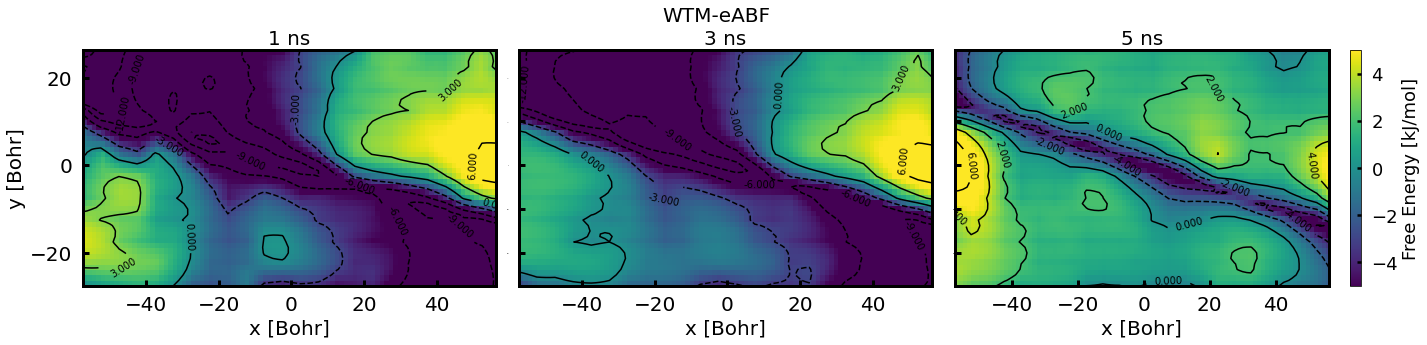

In [17]:
# Plotting
plt.rcParams["figure.figsize"] = [20,5]
plt.rcParams["axes.titlesize"] = 20
vmin = -5
vmax = 5
fig, axs = plt.subplots(ncols=3)
#
CS = axs[0].contour(x, y, meta_eABF_1ns, colors='black', zorder=3)
plt.clabel(CS, CS.levels, inline='true', fontsize=10, fmt="%5.3f")
im0 = axs[0].imshow(meta_eABF_1ns, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], zorder=1, interpolation='None', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
axs[0].tick_params(axis='y',length=6,width=3,labelsize=20, pad=10, direction='in')
axs[0].set(title='1 ns')
axs[0].set_ylabel('y [Bohr]', fontsize=20)
#
CS = axs[1].contour(x, y, meta_eABF_3ns, colors='black', zorder=3)
plt.clabel(CS, CS.levels, inline='true', fontsize=10, fmt="%5.3f")
im1 = axs[1].imshow(meta_eABF_3ns, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], zorder=1, interpolation='None', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
axs[1].tick_params(axis='y',length=6,width=3,labelsize=0, pad=10, direction='in')
axs[1].set(title='3 ns')
#
CS = axs[2].contour(x, y, meta_eABF_5ns, colors='black', zorder=3)
plt.clabel(CS, CS.levels, inline='true', fontsize=10, fmt="%5.3f")
im2 = axs[2].imshow(meta_eABF_5ns, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], zorder=1, interpolation='None', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
axs[2].set(title='5 ns')
axs[2].tick_params(axis='y',length=6,width=3,labelsize=0, pad=0, direction='in')
#
cb2 = plt.colorbar(im2, ax=axs[2], fraction=0.044)
cb2.ax.set_ylabel('Free Energy [kJ/mol]', fontsize=18)
cb2.ax.tick_params(length=4,width=2.5,labelsize=18, pad=10, direction='in')
#
for ax in axs:
    ax.set_xlabel(r'x [Bohr]', fontsize=20)
    ax.spines['bottom'].set_linewidth('3')
    ax.spines['top'].set_linewidth('3')
    ax.spines['left'].set_linewidth('3')
    ax.spines['right'].set_linewidth('3')
    ax.tick_params(axis='x',length=6,width=3,labelsize=20, pad=10, direction='in')
#
fig.suptitle('WTM-eABF', fontsize=20, y=0.95)
plt.tight_layout()
plt.savefig("meta_eABF_diff.png", dpi=400)
plt.show()
plt.close()

In [18]:
ref_traj = np.loadtxt('CV_traj.dat', skiprows=1)
ref_traj

array([[ 0.0000000e+00, -3.9937118e+01, -2.0012184e+01],
       [ 5.0000000e+00, -3.9879665e+01, -2.0029427e+01],
       [ 1.0000000e+01, -3.9826566e+01, -2.0047355e+01],
       ...,
       [ 3.7498500e+05, -3.0326439e+01, -1.9316555e+01],
       [ 3.7499000e+05, -3.0379598e+01, -1.9328592e+01],
       [ 3.7499500e+05, -3.0431208e+01, -1.9340453e+01]])

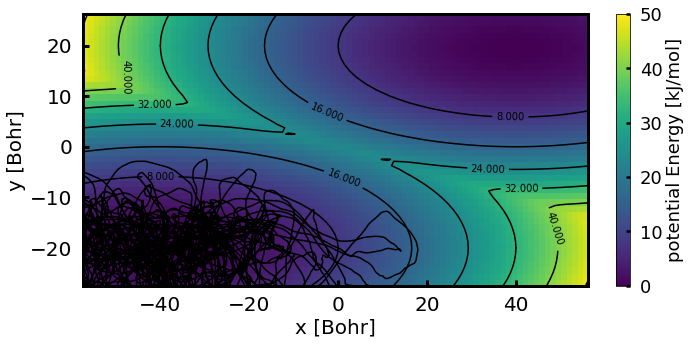

In [21]:
plt.rcParams["figure.figsize"] = [10,5]
plt.rcParams["axes.titlesize"] = 20
vmin = 0
vmax = 50
fig, axs = plt.subplots(ncols=1)
#
CS = axs.contour(x, y, pot(x,y), colors='black', zorder=3)
plt.plot(ref_traj[:,1],ref_traj[:,2],color='black')
plt.clabel(CS, CS.levels, inline='true', fontsize=10, fmt="%5.3f")
im0 = axs.imshow(pot(x,y), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], zorder=1, interpolation='None', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
axs.tick_params(axis='y',length=6,width=3,labelsize=20, pad=10, direction='in')
#axs.set(title='1 ns')

cb2 = plt.colorbar(im0, ax=axs, fraction=0.044)
cb2.ax.set_ylabel('potential Energy [kJ/mol]', fontsize=18)
cb2.ax.tick_params(length=4,width=2.5,labelsize=18, pad=10, direction='in')

axs.set_ylabel('y [Bohr]', fontsize=20)
axs.set_xlabel(r'x [Bohr]', fontsize=20)
axs.spines['bottom'].set_linewidth('3')
axs.spines['top'].set_linewidth('3')
axs.spines['left'].set_linewidth('3')
axs.spines['right'].set_linewidth('3')
axs.tick_params(axis='x',length=6,width=3,labelsize=20, pad=10, direction='in')